In [2]:
import numpy as np
import cv2
from skimage import exposure, filters
import matplotlib.pyplot as plt
import pywt
from skimage import exposure

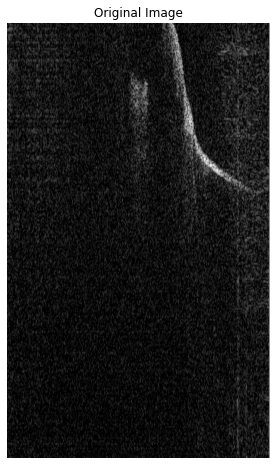

In [3]:
# Read the image
image = cv2.imread('noisyear.png', cv2.IMREAD_GRAYSCALE)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

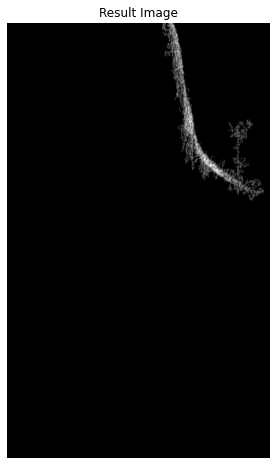

In [4]:
# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Apply histogram equalization to enhance contrast
equalized_image = exposure.equalize_hist(blurred_image)

# Apply edge detection using Canny
edges = cv2.Canny((equalized_image * 255).astype(np.uint8), 30, 70)

# Use morphological operations to remove small noise
kernel = np.ones((3, 3), np.uint8)
cleaned_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Invert the colors to make the region of interest white
cleaned_image_inverse = cv2.bitwise_not(cleaned_image)

# Find contours in the cleaned image
contours, _ = cv2.findContours(cleaned_image_inverse, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract the largest contour (assumes tympanic membrane is the largest region)
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask for the tympanic membrane
mask = np.zeros_like(image)
cv2.drawContours(mask, [largest_contour], 0, 255, thickness=cv2.FILLED)

# Apply the mask to the original image
result_image = cv2.bitwise_and(image, mask)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(result_image, cmap='gray')
plt.title('Result Image')
plt.axis('off')
plt.show()


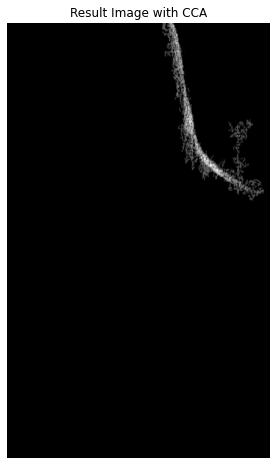

In [5]:




# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Apply histogram equalization to enhance contrast
equalized_image = exposure.equalize_hist(blurred_image)

# Apply edge detection using Canny
edges = cv2.Canny((equalized_image * 255).astype(np.uint8), 30, 70)

# Use morphological operations to remove small noise
kernel = np.ones((3, 3), np.uint8)
cleaned_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Invert the colors to make the region of interest white
cleaned_image_inverse = cv2.bitwise_not(cleaned_image)

# Apply Connected Component Analysis (CCA)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned_image_inverse)

# Find the index of the largest connected component (excluding background)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# Create a mask for the largest connected component
mask = (labels == largest_component_index).astype(np.uint8) * 255

# Apply the mask to the original image
result_image = cv2.bitwise_and(image, mask)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(result_image, cmap='gray')
plt.title('Result Image with CCA')
plt.axis('off')
plt.show()


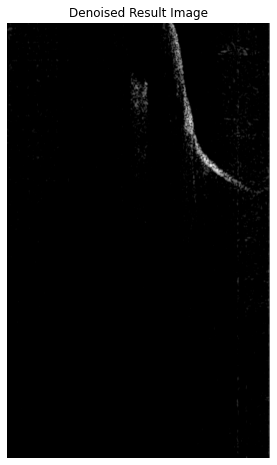

In [6]:

# Load your OCT scan image (replace 'your_image_path' with the actual path)
# image = cv2.imread('your_image_path', cv2.IMREAD_GRAYSCALE)

# Apply wavelet decomposition (using Haar wavelet as an example, you can choose other wavelets)
coeffs = pywt.dwt2(image, 'haar')
cA, (cH, cV, cD) = coeffs

# Threshold the wavelet coefficients to remove noise
threshold = 100  # Adjust this threshold as needed
cA_thresholded = pywt.threshold(cA, threshold, mode='soft')
cH_thresholded = pywt.threshold(cH, threshold, mode='soft')
cV_thresholded = pywt.threshold(cV, threshold, mode='soft')
cD_thresholded = pywt.threshold(cD, threshold, mode='soft')

# Reconstruct the denoised image from the thresholded coefficients
denoised_image = pywt.idwt2((cA_thresholded, (cH_thresholded, cV_thresholded, cD_thresholded)), 'haar')

# # Apply FFT for further denoising
# fft_image = np.fft.fft2(denoised_image)
# fft_shift = np.fft.fftshift(fft_image)

# # Define a mask to remove high-frequency noise in FFT domain
# rows, cols = image.shape
# crow, ccol = rows // 2, cols // 2
# r = 30  # Adjust this radius as needed
# mask = np.ones((rows, cols), np.uint8)
# center = [crow, ccol]
# x, y = np.ogrid[:rows, :cols]
# mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
# mask[mask_area] = 0

# # Apply the mask in FFT domain
# fft_shift_filtered = fft_shift * mask

# # Inverse FFT to obtain the final denoised image
# denoised_fft_image = np.fft.ifft2(np.fft.ifftshift(fft_shift_filtered)).real

# # Apply histogram equalization to enhance contrast
# equalized_image = exposure.equalize_hist(denoised_fft_image)


#-------------------

# # Apply histogram equalization to enhance contrast
# equalized_image = exposure.equalize_hist(blurred_image)

# # Apply edge detection using Canny
# edges = cv2.Canny((equalized_image * 255).astype(np.uint8), 40, 80)

# # # Use morphological operations to remove small noise
# # kernel = np.ones((3, 3), np.uint8)
# # cleaned_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# # Invert the colors to make the region of interest white
# cleaned_image_inverse = cv2.bitwise_not(edges)

# # Display the result
# plt.figure(figsize=(8, 8))
# # plt.imshow(equalized_image, cmap='gray')

# plt.imshow(cleaned_image_inverse, cmap='gray')
# plt.title('Denoised Result Image')
# plt.axis('off')
# plt.show()


#-------------------



# Display the result
plt.figure(figsize=(8, 8))
# plt.imshow(equalized_image, cmap='gray')

plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Result Image')
plt.axis('off')
plt.show()


error: OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1658893788286/work/modules/core/src/arithm.cpp:214: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


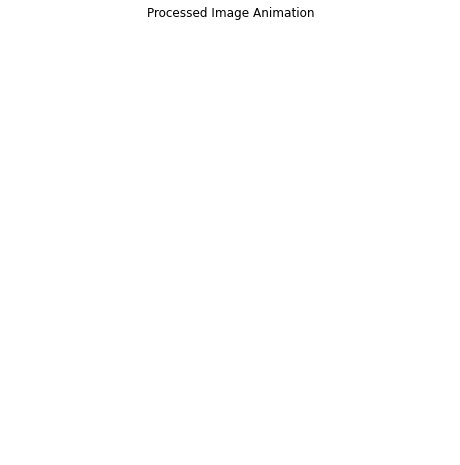

In [52]:
import numpy as np
import cv2
from skimage import exposure, filters
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio

# Function to process and clean a single slice
def process_slice(slice_image):
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(slice_image, (5, 5), 0)

    # Apply histogram equalization to enhance contrast
    equalized_image = exposure.equalize_hist(blurred_image)

    # Apply edge detection using Canny
    edges = cv2.Canny((equalized_image * 255).astype(np.uint8), 30, 70)

    # Use morphological operations to remove small noise
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Invert the colors to make the region of interest white
    cleaned_image_inverse = cv2.bitwise_not(cleaned_image)

    # Apply Connected Component Analysis (CCA)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned_image_inverse)

    # Find the index of the largest connected component (excluding background)
    largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Create a mask for the largest connected component
    mask = (labels == largest_component_index).astype(np.uint8) * 255

    # Apply the mask to the original slice
    result_slice = cv2.bitwise_and(slice_image, mask)

    return result_slice

# Load the .tiff file
file_path = 'fused_volume1.tif'
# image_stack = imageio.imread(file_path)
image_stack = imageio.v2.imread(file_path)

# Create a figure and axis for displaying the animation
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Processed Image Animation')
plt.axis('off')

# Function to update the displayed image in the animation
def update(frame):
    ax.imshow(process_slice(image_stack[frame]), cmap='gray')

# Create the animation
animation = FuncAnimation(fig, update, frames=len(image_stack), interval=200)

FuncAnimation.save(animation,"animation.mp4");

# Display the animation
plt.show()
